# What is the True Normal Human Body Temperature? 

#### Background

The mean normal body temperature was held to be 37$^{\circ}$C or 98.6$^{\circ}$F for more than 120 years since it was first conceptualized and reported by Carl Wunderlich in a famous 1868 book. But, is this value statistically correct?

<h3>Exercises</h3>

<p>In this exercise, you will analyze a dataset of human body temperatures and employ the concepts of hypothesis testing, confidence intervals, and statistical significance.</p>

<p>Answer the following questions <b>in this notebook below and submit to your Github account</b>.</p> 

<ol>
<li>  Is the distribution of body temperatures normal? 
    <ul>
    <li> Although this is not a requirement for the Central Limit Theorem to hold (read the introduction on Wikipedia's page about the CLT carefully: https://en.wikipedia.org/wiki/Central_limit_theorem), it gives us some peace of mind that the population may also be normally distributed if we assume that this sample is representative of the population.
    <li> Think about the way you're going to check for the normality of the distribution. Graphical methods are usually used first, but there are also other ways: https://en.wikipedia.org/wiki/Normality_test
    </ul>
<li>  Is the sample size large? Are the observations independent?
    <ul>
    <li> Remember that this is a condition for the Central Limit Theorem, and hence the statistical tests we are using, to apply.
    </ul>
<li>  Is the true population mean really 98.6 degrees F?
    <ul>
    <li> First, try a bootstrap hypothesis test.
    <li> Now, let's try frequentist statistical testing. Would you use a one-sample or two-sample test? Why?
    <li> In this situation, is it appropriate to use the $t$ or $z$ statistic? 
    <li> Now try using the other test. How is the result be different? Why?
    </ul>
<li>  Draw a small sample of size 10 from the data and repeat both frequentist tests. 
    <ul>
    <li> Which one is the correct one to use? 
    <li> What do you notice? What does this tell you about the difference in application of the $t$ and $z$ statistic?
    </ul>
<li>  At what temperature should we consider someone's temperature to be "abnormal"?
    <ul>
    <li> As in the previous example, try calculating everything using the boostrap approach, as well as the frequentist approach.
    <li> Start by computing the margin of error and confidence interval. When calculating the confidence interval, keep in mind that you should use the appropriate formula for one draw, and not N draws.
    </ul>
<li>  Is there a significant difference between males and females in normal temperature?
    <ul>
    <li> What testing approach did you use and why?
    <li> Write a story with your conclusion in the context of the original problem.
    </ul>
</ol>

You can include written notes in notebook cells using Markdown: 
   - In the control panel at the top, choose Cell > Cell Type > Markdown
   - Markdown syntax: http://nestacms.com/docs/creating-content/markdown-cheat-sheet

#### Resources

+ Information and data sources: http://www.amstat.org/publications/jse/datasets/normtemp.txt, http://www.amstat.org/publications/jse/jse_data_archive.htm
+ Markdown syntax: http://nestacms.com/docs/creating-content/markdown-cheat-sheet

****

In [6]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats
import statsmodels.api as sm


df = pd.read_csv('data/human_body_temperature.csv')

Perform cursory data analysis

In [10]:
df.head()

,temperature,gender,heart_rate
0,99.3,F,68.0
1,98.4,F,81.0
2,97.8,M,73.0
3,99.2,F,66.0
4,98.0,F,73.0


In [12]:
np.sum(df.isnull())

temperature    0
gender         0
heart_rate     0
dtype: int64

In [13]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 130 entries, 0 to 129
Data columns (total 3 columns):
temperature    130 non-null float64
gender         130 non-null object
heart_rate     130 non-null float64
dtypes: float64(2), object(1)
memory usage: 3.1+ KB


In [14]:
df[df.duplicated(keep=False)].sort_values('temperature')

,temperature,gender,heart_rate
72,98.0,M,78.0
87,98.0,M,78.0
54,98.2,F,73.0
127,98.2,F,73.0
7,98.8,M,78.0
75,98.8,M,78.0


# 1. Is the distribution of body temperatures normal

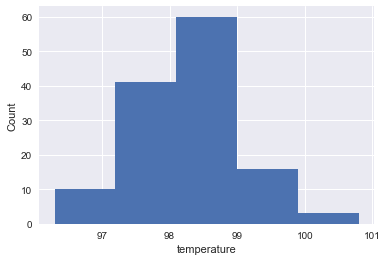

In [15]:
# Plot histogram

sns.set()

_ = plt.hist(df.temperature, bins = 5)
_ = plt.xlabel('temperature')
_ = plt.ylabel('Count')
plt.show()


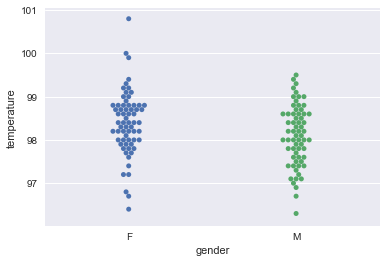

In [16]:
# Create swarm plot

_ = sns.swarmplot(x = 'gender', y = 'temperature', data = df)
_ = plt.xlabel('gender')
_ = plt.ylabel('temperature')
plt.show()

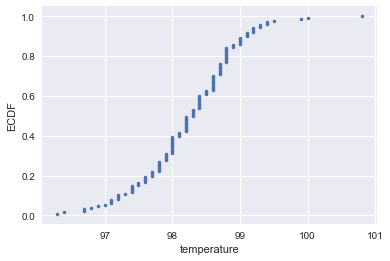

In [17]:
# Calculate the ECDF

def ecdf(data):
    # number of data points
    n = len(data)
    
    # x-data for ECDF
    x = np.sort(data)
    
    # y data for ecdf
    y = np.arange(1, len(x) + 1) / n 
    
    return x, y

x_temp, y_temp = ecdf(df.temperature)

# Plot ECDF

_ = plt.plot(x_temp, y_temp, marker = '.', linestyle = 'none')
_ = plt.xlabel('temperature')
_ = plt.ylabel('ECDF')
plt.show()

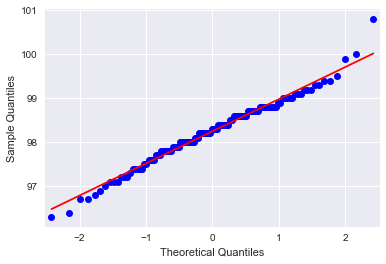

In [18]:
## Prob/QQ Plot as a final check for normality 
sm.qqplot(df.temperature, line = 's')
plt.show()


Using PDF, CDF and QQ Plotting, the data appears to be normally distributed

# 2. Is the sample size large? Are the observations independent

In [19]:
len(df['temperature']) > 30

True

The sample size is sufficient, as it is above 30

The data is considered independent as the value of each observation does not depend on another observation

#  Is the true population mean really 98.6 degrees F?

First we will define some utility functions for creating replicate statistics for bootstrapping

In [20]:
# Function for selecting random observations with replacement
def bs_reps(arr, func):
    return func(np.random.choice(arr, size = len(arr)))


# Function for creating an array of replicate statistics with the above function nested inside
def draw_bs_reps(arr, func, size = 1):
    bs_replicates = np.empty(size)
    
    for i in range(size):
        bs_replicates[i] = bs_reps(arr, func)
    return bs_replicates



Compute relevent statistics

In [21]:
mean_temp = np.mean(df['temperature'])
std_temp = np.std(df['temperature'])
alpha = 0.05 # our significance level for 95% confidence


# And by gender

# mean
mean_male_temp = np.mean(df['temperature'][df.gender == 'M'])

mean_female_temp = np.mean(df['temperature'][df.gender == 'F'])

# std
std_male_temp = np.std(df['temperature'][df.gender == 'M'])

std_female_temp = np.std(df['temperature'][df.gender == 'F'])


Perform one-sampled (we only have our observed data and one value (the presumptive mean of the population) bootstrap hypothesis test. Our null hypothesis is that the true population mean is 98.6



In [23]:
# Shift the mean of the data to the assumed true mean

shifted_temp = df.temperature - mean_temp + 98.6

# Create replicates

reps = draw_bs_reps(shifted_temp, np.mean, 10000)

# Determine the p value as the sum of all our replicates with a more extreme mean temperature than our observed mean divided by 
# the length of our replicate array

p = np.sum(reps <= mean_temp) / len(reps)

p > alpha

False

The p value is well below the significance level (alpha), therefore we can reject the null hypothesis that the true mean of the temperature is 98.6. Now we will perform frequentist testing using z and t testing

In [27]:
# Compute standard error of the mean
st_err = std_temp / np.sqrt(len(df.temperature))

# Compute z statistic
z = (mean_temp - 98.6)/st_err

p = stats.norm.cdf(z) * 2

print(z)
print(p)


-5.47592520208
4.35231516588e-08


Our p value using our z statistic is well below our alpha. Now we will perform a t test

In [28]:
t, p = stats.ttest_1samp(df.temperature, 98.6)

ppf_range = stats.t.ppf(0.025, len(df.temperature)) # 0.025 since this is a two tailed test

t >= ppf_range

False

T is outside of the T-dist range on the left side. We can reject our null hypothesis using this methodology as well

# Draw a small sample of size 10 from the data and repeat both frequentist tests

We take a randomly selected sample (with replacement) from our observed data and repeat the above testing.

In [32]:
sample = np.random.choice(df['temperature'], size = 10)

st_err_samp = np.std(sample)/np.sqrt(len(sample))

z_samp = (np.mean(sample) - 98.6 ) / st_err_samp

print('Z:' + str(z_samp))

p_samp = stats.norm.cdf(z) * 2 # Two tailed 

print('P:' + str(p_samp))


Z:0.594379959959
P:4.35231516588e-08


The p value is well below our 95% confidence threshold

In [33]:
sample = np.random.choice(df['temperature'], size = 10)

t_samp, p_samp = stats.ttest_1samp(sample, 98.6)

ppf_range_samp = stats.t.ppf(0.025, len(sample))

t >= ppf_range_samp

False

As with our z test, our t test is also below our confidence interval of 0.05. We can reject the null hypothesis again. 

#  At what temperature should we consider someone's temperature to be "abnormal"

We will define "abnormal" here as outside of 3 standard deviations of the observed mean. Since we are peforming this calculation for "one-draw" as opposed to n, we will utilize the stats interval function and create a subset of outliers

In [34]:
interval = stats.norm.interval(0.997, mean_temp, std_temp)

In [36]:
outliers = df[(df.temperature <= interval[0]) | (df.temperature >= interval[1])]

print(interval)

print(outliers)

(96.081720289705913, 100.41674124875564)
     temperature gender  heart_rate
116        100.8      F        77.0


# Is there a significant difference between males and females in normal temperature?

We will start by performing graphical data analysis, followed by quantative data analysis

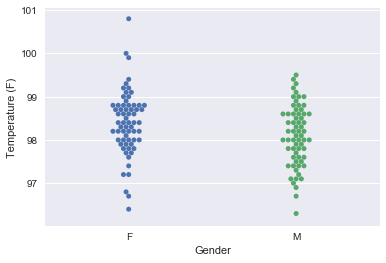

In [37]:
# Check swarm plot

sns.swarmplot(x = 'gender', y = 'temperature', data = df)
plt.xlabel('Gender')
plt.ylabel('Temperature (F)')
plt.show()


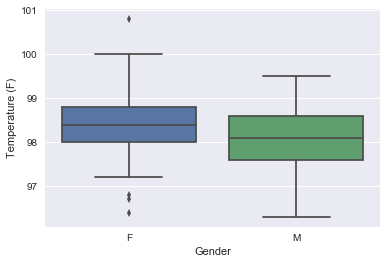

In [38]:
# Check box plot

sns.boxplot(x = 'gender', y = 'temperature', data = df)
plt.xlabel('Gender')
plt.ylabel('Temperature (F)')
plt.show()

We see a noticable difference in the mean between both groups, with women having a higher body temperature on average and having more variance. We will now perform a two-sampled hypothesis test to determine if this observed difference is significant. This will be done using a simulation/bootstrapping method. We will use mean as a proxy for normal temperature. We will use a significance level of 0.05.

In [41]:
# Empirical differences of means

emp_diff_means = np.abs(mean_female_temp - mean_male_temp)

# Shift both subpopulations' means to be the same as the sample mean since we are assuming men and women have t
male_shifted = df['temperature'][(df.gender == 'M')] - mean_male_temp + mean_temp
fem_shifted = df['temperature'][(df.gender == 'F')] - mean_female_temp + mean_temp


# Using our bootstrapping functions, we will create two replicate sets for each subpopulation.
bs_reps_m = draw_bs_reps(male_shifted, np.mean, size = 10000)
bs_reps_f = draw_bs_reps(fem_shifted, np.mean, size = 10000)

# Compute the difference in mean for each 10000 replicate
replicants = bs_reps_f - bs_reps_m

# Calculate p value
p = np.sum(replicants >= emp_diff_means) / 10000

print(p)


0.0111


Based off our simulation, we reject the null hypothesis that the mean temperature of men and women is the same.